In [4]:
import pydot
import numpy as np
from IPython.display import display, Javascript, SVG
from pydrake.examples.manipulation_station import ManipulationStation
from manipulation.scenarios import (
    AddIiwa, AddShape
)
from manipulation.meshcat_cpp_utils import (
    StartMeshcat, AddMeshcatTriad
)
from pydrake.all import (
    AddMultibodyPlantSceneGraph, BasicVector, DiagramBuilder, MeshcatVisualizerCpp, MeshcatVisualizerParams, Parser, 
    RollPitchYaw, RigidTransform, RevoluteJoint, Sphere, Simulator, InverseDynamicsController, MultibodyPlant, PiecewisePolynomial,
    PiecewiseQuaternionSlerp, TrajectorySource,
    RotationMatrix, Rgba, LeafSystem, Integrator, PassThrough, Demultiplexer
)
import pydrake.all

import pandas as pd

def dataframe(trajectory, times, names):
    assert trajectory.rows() == len(names)
    values = trajectory.vector_values(times)
    data = {'t': times }
    for i in range(len(names)):
        data[names[i]] = values[i,:]
    return pd.DataFrame(data)

In [5]:
meshcat = StartMeshcat()

In [30]:
BASE_MASS = 1000

In [9]:
def AddFloatingIiwa(plant, collision_model="no_collision"):
    sdf_path = "iiwa_rock_climbing/models/iiwa_description/iiwa7/" + \
        f"iiwa7_{collision_model}.sdf"

    parser = Parser(plant)
    iiwa = parser.AddModelFromFile(sdf_path)
    # Set default positions:
    q0 = [0.0, 0.1, 0, -1.2, 0, 1.6, 0]
    index = 0
    for joint_index in plant.GetJointIndices(iiwa):       
        joint = plant.get_mutable_joint(joint_index)
        if isinstance(joint, RevoluteJoint):
            joint.set_default_angle(q0[index])
            index += 1
        
    return iiwa

def AddFloatingBase(plant, iiwa, mass=BASE_MASS):
    base = AddShape(plant, pydrake.geometry.Box(0.2,0.2,0.2), "mobile_base", 
                    mass=mass, mu=1, color=[.5, .5, .9, 1.0])
    plant.WeldFrames(plant.GetFrameByName("mobile_base"), 
                     plant.GetFrameByName("iiwa_link_0"),
                     RigidTransform(RollPitchYaw(0, 0, 0), [0, 0, 0.1]))
    return base

In [10]:
def AddMeshcatSphere(meshcat,
                     path,
                     radius=0.01,
                     opacity=1.,
                     p_WP=np.array([0,0,0])):
    
    X_WP = RigidTransform(RotationMatrix(),
                          p_WP)
    meshcat.SetTransform(path, X_WP)
    meshcat.SetObject(path, Sphere(radius),
                      Rgba(1, 0, 0, opacity))

In [185]:
class PseudoInverseController(LeafSystem):
    """
    Inputs: 
    + cartesian_position_desired
    + cartesian_position_estimated
    
    Outputs:
    + joint_torques
    
    TODO: 
    """
    def __init__(self, plant):
        LeafSystem.__init__(self)
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()
        self._iiwa = plant.GetModelInstanceByName("iiwa7")
        self._G = plant.GetBodyByName("iiwa_link_7").body_frame()
        self._W = plant.world_frame()

        self.p_WG_des_port = self.DeclareVectorInputPort("cartesian_position_desired", BasicVector(3))
        # self.p_WG_est_port = self.DeclareVectorInputPort("cartesian_position_estimated", BasicVector(3))
        self.q_port = self.DeclareVectorInputPort("iiwa_position", BasicVector(7))
        self.q_dot_port = self.DeclareVectorInputPort("iiwa_velocity", BasicVector(7))
        self.output_port = self.DeclareVectorOutputPort("joint_torques", BasicVector(7), 
                                     self.calc_output)
        
        # TODO(russt): Add missing binding
        #joint_indices = plant.GetJointIndices(self._iiwa)
        #self.position_start = plant.get_joint(joint_indices[0]).position_start()
        #self.position_end = plant.get_joint(joint_indices[-1]).position_start()
        # self.iiwa_start = plant.GetJointByName("iiwa_joint_1").velocity_start()
        # self.iiwa_end = plant.GetJointByName("iiwa_joint_7").velocity_start()

    def get_input_p_WG_des_port(self):
        return self.p_WG_des_port
        
    def get_input_q_port(self):
        return self.q_port

    def get_input_q_dot_port(self):
        return self.q_dot_port
    
    def get_output_port_control(self):
        return self.output_port
    
    def calc_output(self, context, output):
        """
        Compute iiwa joint torque commands
        
        Currently only handles position
        """
        
        # Read position data
        p_WG_des = self.p_WG_des_port.Eval(context)
        
        # Update controller plant
        q = self.q_port.Eval(context)
        self._plant.SetPositions(self._plant_context, self._iiwa, q)
        
        # Compute forward kinematics
        gripper = self._plant.GetBodyByName("iiwa_link_7")
        X_WG_est = self._plant.EvalBodyPoseInWorld(self._plant_context, gripper)

        # Compute distance between points
        print("HEREEE")
        print(p_WG_des)
        print(X_WG_est)
        # print
        # V_G = np.hstack([w_G, v_G])
        
        
        # w_G = self.w_G_port.Eval(context)
        # v_G = self.v_G_port.Eval(context)
        # V_G = np.hstack([w_G, v_G])
        # q = self.q_port.Eval(context)
        # self._plant.SetPositions(self._plant_context, self._iiwa, q)
        # J_G = self._plant.CalcJacobianSpatialVelocity(
        #     self._plant_context, JacobianWrtVariable.kV, 
        #     self._G, [0,0,0], self._W, self._W)
        # J_G = J_G[:,self.iiwa_start:self.iiwa_end+1] # Only iiwa terms.
        # v = np.linalg.pinv(J_G).dot(V_G)
        # output.SetFromVector(v)

                # Desired force in end effector frame
        # f_G 
        
#         J_G = self._plant.CalcJacobianSpatialVelocity(
#             self._plant_context, JacobianWrtVariable.kV, 
#             self._G, [0,0,0], self._W, self._W)
#         J_G = J_G[:,self.iiwa_start:self.iiwa_end+1] # Only iiwa terms.
               
#         p_WG_est = np.linalg.pinv(J_G).dot(q)
#         print(p_WG_est)
        # tau = np.linalg.pinv(J_G).dot(f_G)
        
        tau = np.ones(7)*-1
        output.SetFromVector(tau)        
        

In [193]:
class IIWA_Climber():
    def __init__(self, traj=None):
        builder = DiagramBuilder()
        
        self.plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)

        self.iiwa = AddFloatingIiwa(self.plant)
        base = AddFloatingBase(self.plant, self.iiwa)
        parser = Parser(self.plant)

        # gripper = parser.AddModelFromFile("models/gripper.sdf")
        # rock = parser.AddModelFromFile("models/rock.sdf")
        # plant.WeldFrames(
        #     plant.GetFrameByName("iiwa_link_7"), 
        #     plant.GetFrameByName("base_link"), 
        #     RigidTransform(RollPitchYaw(0, -np.pi/2, 0), [0, 0, 0.25]))
        
        self.plant.gravity_field().set_gravity_vector([0., 0., -0.1])    

        self.plant.Finalize()

        visualizer = MeshcatVisualizerCpp.AddToBuilder(
            builder, 
            scene_graph, 
            meshcat,
            MeshcatVisualizerParams(delete_prefix_initialization_event=False))
        
        
        # Export the iiwa "state" outputs.
        num_iiwa_positions = self.plant.num_positions(self.iiwa)
        demux = builder.AddSystem(Demultiplexer([num_iiwa_positions, num_iiwa_positions])) # 7 for position, 7 for velocity state (one for each joint)
        builder.Connect(self.plant.get_state_output_port(self.iiwa), demux.get_input_port())    
        iiwa_position_port = builder.ExportOutput(demux.get_output_port(0), "iiwa_position_measured")
        iiwa_velocity_port = builder.ExportOutput(demux.get_output_port(1), "iiwa_velocity_estimated")
        iiwa_state_port = builder.ExportOutput(self.plant.get_state_output_port(self.iiwa), "iiwa_state_estimated")
        
            
        # Set up controller ----------------------------------------        

        controller_plant = MultibodyPlant(time_step = 1e-2)
        controller_iiwa = AddFloatingIiwa(controller_plant)
        controller_base = AddFloatingBase(controller_plant, controller_iiwa)
        controller_parser = Parser(controller_plant)
        controller_plant.Finalize()

        self.iiwa_controller = builder.AddSystem(PseudoInverseController(controller_plant))
        self.iiwa_controller.set_name("iiwa_controller");
        builder.Connect(demux.get_output_port(0),
                        self.iiwa_controller.get_input_q_port())
        builder.Connect(demux.get_output_port(1),
                        self.iiwa_controller.get_input_q_dot_port())
        builder.Connect(self.iiwa_controller.get_output_port_control(),
                        self.plant.get_actuation_input_port())
        
        self.traj = traj
        if traj:
            p_G_source = builder.AddSystem(TrajectorySource(traj["traj_p_G"]))
            p_G_source.set_name("p_WG")
            builder.Connect(p_G_source.get_output_port(), self.iiwa_controller.GetInputPort("cartesian_position_desired"))
#             builder.Connect(w_G_source.get_output_port(), self.iiwa_controller.GetInputPort("omega_WG"))

#             integrator = builder.AddSystem(Integrator(7))
#             integrator.set_name("integrator")
#             builder.Connect(controller.get_output_port(), 
#                             integrator.get_input_port())
#             builder.Connect(integrator.get_output_port(),
#                             self.plant.GetInputPort("iiwa_position"))
#             builder.Connect(self.plant.GetOutputPort("iiwa_position_measured"),
#                             controller.GetInputPort("iiwa_position"))
        
        
        
        # Build
        self.diagram = builder.Build()
        self.gripper_frame = self.plant.GetFrameByName("iiwa_link_7")
        self.world_frame = self.plant.world_frame()
        
        context = self.CreateDefaultContext()
        self.diagram.Publish(context)
                
        
    def CreateDefaultContext(self):
        context = self.diagram.CreateDefaultContext()
        plant_context = self.diagram.GetMutableSubsystemContext(self.plant, context)

        # Set initial positions 
        q0 = np.array([-1.57, 0.1, 0, -1.2, 0, 1.6, 0])
        # x0 = np.hstack((q0, 0*q0))
        # x0 = np.array([1,2,3])

        plant_context = self.plant.GetMyMutableContextFromRoot(context)

        self.plant.SetPositions(plant_context, self.iiwa, q0)
        
        # NOTE: THIS LINE OF CODE IS USEFUL FOR SETTING FIXED ROTATION VALUES
        # self.plant.get_actuation_input_port().FixValue(plant_context, np.ones(7)*0.1)
        # TODO: UNCOMMENT THIS:
        
        # Set torques to 0 if no trajectory input
        if not self.traj:
             # self.iiwa_controller.GetInputPort('cartesian_position_desired').FixValue(self.iiwa_controller.GetMyMutableContextFromRoot(context), x0)

        
        
        
        
#         # provide initial states
#         q0 = np.array([ 1.40666193e-05,  1.56461165e-01, -3.82761069e-05, 
#                        -1.32296976e+00, -6.29097287e-06,  1.61181157e+00, -2.66900985e-05])
#         # set the joint positions of the kuka arm
#         self.station.SetIiwaPosition(station_context, q0)
#         self.station.SetIiwaVelocity(station_context, np.zeros(7))
#         self.station.SetWsgPosition(station_context, 0.1)
#         self.station.SetWsgVelocity(station_context, 0)

#         if hasattr(self, 'integrator'):
#             self.integrator.set_integral_value(
#                 self.integrator.GetMyMutableContextFromRoot(context), 
#                 self.station.GetIiwaPosition(station_context))

        return context
    
    
    def visualize_frame(self, name, X_WF, length=0.15, radius=0.006):
        """
        visualize imaginary frame that are not attached to existing bodies
        
        Input: 
            name: the name of the frame (str)
            X_WF: a RigidTransform to from frame F to world.
        
        Frames whose names already exist will be overwritten by the new frame
        """
        AddMeshcatTriad(meshcat, "climber/" + name,
                        length=length, radius=radius, X_PT=X_WF)
        
    def visualize_com(self, name, p_WP, radius=0.06):
        """
        visualize center of mass
        
        Input: 
            name: the name of the frame (str)
            p_WP: a position from a point P to world.
        
        Frames whose names already exist will be overwritten by the new frame
        """
        AddMeshcatSphere(meshcat, "climber/" + name,
                         radius=radius, p_WP=p_WP)
        
        
    def get_X_WG(self, context=None):
        if not context:
            context = self.CreateDefaultContext()
        plant_context = self.plant.GetMyMutableContextFromRoot(context)
        X_WG = self.plant.CalcRelativeTransform(
                    plant_context,
                    frame_A=self.world_frame,
                    frame_B=self.gripper_frame)
        return X_WG
    
    def run(self):
        context = self.CreateDefaultContext()
        simulator = Simulator(self.diagram, context)
        simulator.set_target_realtime_rate(0.25)
        simulator.AdvanceTo(2.0)

In [194]:
def make_gripper_frames(X_G, X_O):
    """
    Takes a partial specification with X_G["initial"] and X_O["initial"] and X_0["goal"], and 
    returns a X_G and times with all of the pick and place frames populated.
    """
    # Define (again) the gripper pose relative to the object when in grasp.
    p_GgraspO = [0, 0.12, 0]
    R_GgraspO = RotationMatrix.MakeXRotation(np.pi/2.0).multiply(
      RotationMatrix.MakeZRotation(np.pi/2.0))
    X_GgraspO = RigidTransform(R_GgraspO, p_GgraspO)
    X_OGgrasp = X_GgraspO.inverse()
    # pregrasp is negative y in the gripper frame (see the figure!).
    X_GgraspGpregrasp = RigidTransform([0, -0.08, 0])

    X_G["pick"] = X_O["initial"].multiply(X_OGgrasp)
    X_G["prepick"] = X_G["pick"].multiply(X_GgraspGpregrasp)
    # X_G["place"] = X_O["goal"].multiply(X_OGgrasp)
    # X_G["preplace"] = X_G["place"].multiply(X_GgraspGpregrasp)

    # # I'll interpolate a ahlfway orientation by converting to axis angle and halving the angle.
    # X_GprepickGpreplace = X_G["prepick"].inverse().multiply(X_G["preplace"])
    # angle_axis = X_GprepickGpreplace.rotation().ToAngleAxis()
    # X_GprepickGclearance = RigidTransform(AngleAxis(angle=angle_axis.angle()/2.0, axis=angle_axis.axis()), 
    #                                     X_GprepickGpreplace.translation()/2.0 + np.array([0, -0.3, 0]))
    # X_G["clearance"] = X_G["prepick"].multiply(X_GprepickGclearance)

    # Now let's set the timing
    times = {"initial": 0}
    X_GinitialGprepick = X_G["initial"].inverse().multiply(X_G["prepick"])
    times["prepick"] = times["initial"] + 10.0*np.linalg.norm(X_GinitialGprepick.translation())
    # # Allow some time for the gripper to close.
    # times["pick_start"] = times["prepick"] + 2.0
    # times["pick_end"] = times["pick_start"] + 2.0
    # times["postpick"] = times["pick_end"] + 2.0
    # time_to_from_clearance = 10.0*np.linalg.norm(X_GprepickGclearance.translation())
    # times["clearance"] = times["postpick"] + time_to_from_clearance
    # times["preplace"] = times["clearance"] + time_to_from_clearance
    # times["place_start"] = times["preplace"] + 2.0
    # times["place_end"] = times["place_start"] + 2.0
    # times["postplace"] = times["place_end"] + 2.0
    

    return X_G, times

def make_gripper_position_trajectory(X_G, times):
    """
    Constructs a gripper position trajectory from the plan "sketch".
    """
    # The syntax here is a little ugly; we need to pass in a matrix with the samples in the columns.
    # TODO(russt): Add python bindings for the std::vector constructor.
    traj = PiecewisePolynomial.FirstOrderHold(
        [times["initial"], times["prepick"]], np.vstack([X_G["initial"].translation(), X_G["prepick"].translation()]).T)

    # # TODO(russt): I could make this less brittle if I was more careful on the names above, and just look up the pose for every time (in order)
    # traj.AppendFirstOrderSegment(times["pick_start"], X_G["pick"].translation())
    # traj.AppendFirstOrderSegment(times["pick_end"], X_G["pick"].translation())
    # traj.AppendFirstOrderSegment(times["postpick"], X_G["prepick"].translation())
    # traj.AppendFirstOrderSegment(times["clearance"], X_G["clearance"].translation())
    # traj.AppendFirstOrderSegment(times["preplace"], X_G["preplace"].translation())
    # traj.AppendFirstOrderSegment(times["place_start"], X_G["place"].translation())
    # traj.AppendFirstOrderSegment(times["place_end"], X_G["place"].translation())
    # traj.AppendFirstOrderSegment(times["postplace"], X_G["preplace"].translation())

    return traj

def make_gripper_orientation_trajectory(X_G, times):
    """
    Constructs a gripper position trajectory from the plan "sketch".
    """
    traj = PiecewiseQuaternionSlerp();
    traj.Append(times["initial"], X_G["initial"].rotation())
    traj.Append(times["prepick"], X_G["prepick"].rotation())
    # traj.Append(times["pick_start"], X_G["pick"].rotation())
    # traj.Append(times["pick_end"], X_G["pick"].rotation())
    # traj.Append(times["postpick"], X_G["prepick"].rotation())
    # traj.Append(times["clearance"], X_G["clearance"].rotation())
    # traj.Append(times["preplace"], X_G["preplace"].rotation())
    # traj.Append(times["place_start"], X_G["place"].rotation())
    # traj.Append(times["place_end"], X_G["place"].rotation())
    # traj.Append(times["postplace"], X_G["preplace"].rotation())

    return traj


In [195]:
# X_G = {"initial": RigidTransform(RotationMatrix.MakeXRotation(-np.pi/2.0), [0, -0.25, 0.25])}
# X_O = {"initial": RigidTransform(RotationMatrix.MakeZRotation(np.pi/2.0), [-.2, -.75, 0.025]),
#        "goal": RigidTransform(RotationMatrix.MakeZRotation(np.pi),[.75, 0, 0.025])}

GOAL_POSE = RigidTransform(RotationMatrix(RollPitchYaw([-np.pi,0,np.pi/2.0])),[.05, -0.70, 0.55])

X_G = {"initial": climber.get_X_WG()}
X_O = {"initial": climber.get_X_WG(),
       "goal": GOAL_POSE}
X_G, times = make_gripper_frames(X_G, X_O)
# X_G
# times

In [196]:
traj_p_G = make_gripper_position_trajectory(X_G, times)
# traj_v_G = traj_p_G.MakeDerivative()
# traj_R_G = make_gripper_orientation_trajectory(X_G, times)
# traj_w_G = traj_R_G.MakeDerivative()

data = dataframe(traj_p_G, traj_p_G.get_segment_times(), ['x','y','z'])
data

,t,x,y,z
0,0.0,0.000354,-0.444084,0.866708
1,2.0,0.000392,-0.491934,0.672516


In [197]:
p0 = [0, 0, 0]
R0 = RotationMatrix(np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype=float).T)
X_WorldCenter = RigidTransform(R0, p0)

traj = {"traj_p_G": traj_p_G}
climber = IIWA_Climber(traj)

# climber = IIWA_Climber()

In [198]:
X_WG = climber.get_X_WG()
climber.visualize_frame('gripper_current', X_WG)
climber.visualize_frame('gripper_goal', X_O["goal"])
climber.visualize_frame('world_center', X_WorldCenter)
climber.visualize_com('com_test', np.array([0.5,0.5,0.5]))

In [199]:
climber.run()

HEREEE
[ 3.53636362e-04 -4.44084375e-01  8.66707814e-01]
RigidTransform(
  R=RotationMatrix([
    [-0.000773199921913291, 0.9999996829318348, 0.0001905206313784219],
    [0.9709578572896668, 0.0007963267107333861, -0.23924925335563638],
    [-0.23924932921398243, 2.0150049340510336e-16, -0.9709581651495911],
  ]),
  p=[0.0003536363619349403, -0.4440843752212391, 0.8667078137695522],
)
HEREEE
[ 3.53655414e-04 -4.44108300e-01  8.66610718e-01]
RigidTransform(
  R=RotationMatrix([
    [-0.002772983564656841, 0.9999961477179086, 0.0001229288135952892],
    [0.9709250432595125, 0.0027217949258061935, -0.23936823557835876],
    [-0.23936764805141283, -0.0005444095195019236, -0.9709288504749514],
  ]),
  p=[0.0003476561391162713, -0.44409267026411436, 0.8667078962766988],
)
HEREEE
[ 3.53674466e-04 -4.44132225e-01  8.66513622e-01]
RigidTransform(
  R=RotationMatrix([
    [-0.006772543490200995, 0.9999770659894347, -1.2240762248849897e-05],
    [0.970847915976196, 0.00657232750068495, -0.2396061

In [165]:
# See this for custom controller info https://stackoverflow.com/questions/68969628/confusion-about-implementing-leafsystem-with-vector-output-port-correctly

In [166]:
# AddMeshcatTriad(meshcat, "climber/" + "iiwa_link_0",
#                 length=2, radius=0.1, X_PT=X_WF)

In [167]:
# X_WF


# AddMeshcatTriad(meshcat, "painter/" + name,
#                 length=length, radius=radius, X_PT=X_WF)

In [33]:
# simulator = Simulator(diagram, context)
# simulator.set_target_realtime_rate(0.25)
# simulator.AdvanceTo(2.0)

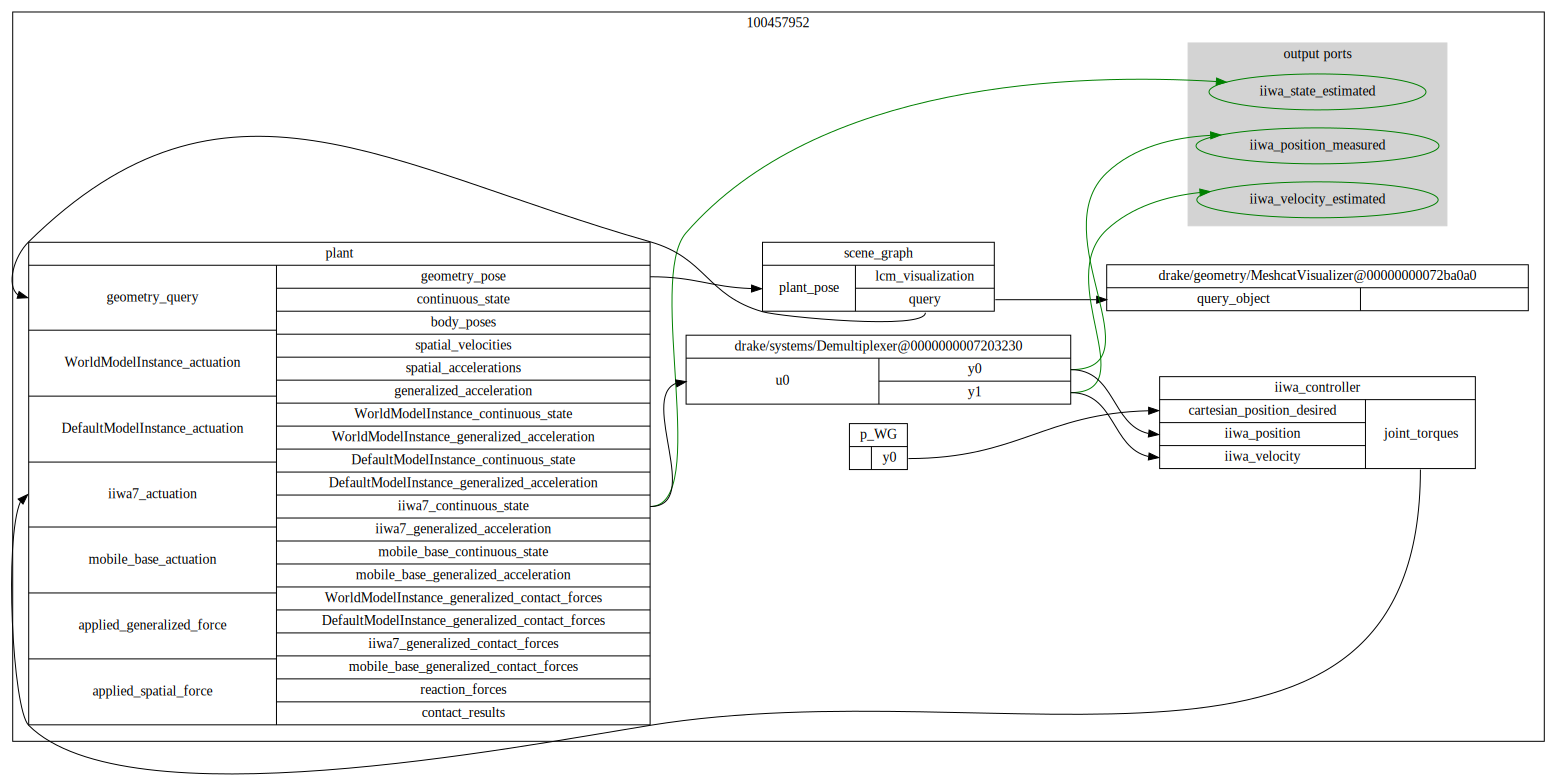

In [159]:
display(SVG(pydot.graph_from_dot_data(climber.diagram.GetGraphvizString())[0].create_svg()))

In [ ]:
import numpy as np
import pydrake.all
import pydot

builder = pydrake.systems.framework.DiagramBuilder()

# Adds both MultibodyPlant and the SceneGraph, and wires them together.
plant, scene_graph = pydrake.multibody.plant.AddMultibodyPlantSceneGraph(builder, time_step=0)
# Note that we parse into both the plant and the scene_graph here.
flair = pydrake.multibody.parsing.Parser(plant, scene_graph).AddModelFromFile("/home/russt/Downloads/flair.urdf")
# Don't Weld Frame for Free-Floating Bodies.
# plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("Base_SC"))
# Reduce/remove gravity
plantGravityField = plant.gravity_field()
plantGravityField.set_gravity_vector([0,0,0])
plant.Finalize()

# Adds the MeshcatVisualizer and wires it to the SceneGraph.
meshcat = pydrake.systems.meshcat_visualizer.ConnectMeshcatVisualizer(builder, scene_graph, zmq_url="tcp://127.0.0.1:6000", delete_prefix_on_load=True)


diagram = builder.Build()
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyMutableContextFromRoot(context)
# plant.SetPositions(plant_context, [0, 0, 0, 0, 0, 0])
plant.get_actuation_input_port().FixValue(plant_context, np.zeros(6))
plant.GetJointByName("Joint_1").set_angular_rate(plant_context, -.25)
plant.get_actuation_input_port().FixValue(plant_context, np.zeros(6))

pydot.graph_from_dot_data(plant.GetTopologyGraphvizString())[0].write_svg("flair_topology.svg")

simulator = pydrake.systems.analysis.Simulator(diagram, context)
simulator.get_mutable_integrator().set_target_accuracy(1e-10)

# Print CoM Value at the Start
print("CoM Location Before Simulation:")
print(plant.CalcCenterOfMassPosition(plant_context, [flair]))

simulator.AdvanceTo(60.0)
print("CoM Location After Simulation")
print(plant.CalcCenterOfMassPosition(plant_context, [flair]))

In [ ]:
# traj_p_G = make_gripper_position_trajectory(X_G, times)
# traj_v_G = traj_p_G.MakeDerivative()
# traj_R_G = make_gripper_orientation_trajectory(X_G, times)
# traj_w_G = traj_R_G.MakeDerivative()

# v_G_source = builder.AddSystem(TrajectorySource(traj_v_G))
# v_G_source.set_name("v_WG")
# w_G_source = builder.AddSystem(TrajectorySource(traj_w_G))
# w_G_source.set_name("omega_WG")
# controller = builder.AddSystem(PseudoInverseController(plant))
# controller.set_name("PseudoInverseController")
# builder.Connect(v_G_source.get_output_port(), controller.GetInputPort("v_WG"))
# builder.Connect(w_G_source.get_output_port(), controller.GetInputPort("omega_WG"))

# integrator = builder.AddSystem(Integrator(7))
# integrator.set_name("integrator")
# builder.Connect(controller.get_output_port(), 
#                 integrator.get_input_port())
# builder.Connect(integrator.get_output_port(),
#                 station.GetInputPort("iiwa_position"))
# builder.Connect(station.GetOutputPort("iiwa_position_measured"),
#                 controller.GetInputPort("iiwa_position"))

# traj_wsg_command = make_wsg_command_trajectory(times)
# wsg_source = builder.AddSystem(TrajectorySource(traj_wsg_command))
# wsg_source.set_name("wsg_command")
# builder.Connect(wsg_source.get_output_port(), station.GetInputPort("wsg_position"))


In [39]:
# class TorqueController(LeafSystem):
#     """Wrapper System for Commanding Pure Torques to planar iiwa.
#     @param plant MultibodyPlant of the simulated plant.
#     @param ctrl_fun function object to implement torque control law.
#     @param vx Velocity towards the linear direction. 
#     """
#     def __init__(self, plant, ctrl_fun, vx):
#         LeafSystem.__init__(self)
#         self._plant = plant 
#         self._plant_context = plant.CreateDefaultContext() 
#         self._iiwa = plant.GetModelInstanceByName("iiwa")
#         self._G = plant.GetBodyByName("body").body_frame()
#         self._W = plant.world_frame()
#         self._ctrl_fun = ctrl_fun 
#         self._vx = vx

#         self.DeclareVectorInputPort("iiwa_position_measured", BasicVector(3))
#         self.DeclareVectorInputPort("iiwa_velocity_measured", BasicVector(3))

#         # If we want, we can add this in to do closed-loop force control on z.
#         #self.DeclareVectorInputPort("iiwa_torque_external", BasicVector(3))

#         self.DeclareVectorOutputPort("iiwa_position_command", BasicVector(3),
#                                      self.CalcPositionOutput)
#         self.DeclareVectorOutputPort("iiwa_torque_cmd", BasicVector(3),
#                                      self.CalcTorqueOutput)
#         # Compute foward kinematics so we can log the wsg position
#         self.DeclareVectorOutputPort("wsg_position", BasicVector(3),
#                                      self.CalcWsgPositionOutput)

#     def CalcPositionOutput(self, context, output):
#         """Set q_d = q_now. This ensures the iiwa goes into pure torque mode in sim by setting the 
#         position control torques in InverseDynamicsController to zero. 
#         NOTE(terry-suh): Do not use this method on hardware or deploy this notebook on hardware. 
#         We can only simulate pure torque control mode for iiwa on sim. 
#         """
#         q_now = self.get_input_port(0).Eval(context)
#         output.SetFromVector(q_now)

#     def CalcTorqueOutput(self, context, output):    
#         # Hard-coded position and force profiles. Can be connected from Trajectory class. 
#         if (context.get_time() < 2.0):
#             px_des = 0.65
#         else:
#             px_des = 0.65 + self._vx * (context.get_time() - 2.0)

#         fz_des = 10 

#         # Read inputs 
#         q_now = self.get_input_port(0).Eval(context)
#         v_now = self.get_input_port(1).Eval(context)
#         #tau_now = self.get_input_port(2).Eval(context) 

#         self._plant.SetPositions(self._plant_context, self._iiwa, q_now)

#         # 1. Convert joint space quantities to Cartesian quantities.
#         X_now = self._plant.CalcRelativeTransform(self._plant_context, self._W, self._G)

#         rpy_now = RollPitchYaw(X_now.rotation()).vector()
#         p_xyz_now = X_now.translation()

#         J_G = self._plant.CalcJacobianSpatialVelocity(
#             self._plant_context, JacobianWrtVariable.kQDot, 
#             self._G, [0,0,0], self._W, self._W)

#         # Only select relevant terms. We end up with J_G of shape (3,3). 
#         # Rows correspond to (pitch, x, z).
#         # Columns correspond to (q0, q1, q2). 
#         J_G = J_G[(1,3,5),7:10]
#         v_pxz_now = J_G.dot(v_now)

#         p_pxz_now = np.array([rpy_now[1], p_xyz_now[0], p_xyz_now[2]])

#         # 2. Apply ctrl_fun 
#         F_pxz = self._ctrl_fun(p_pxz_now, v_pxz_now, px_des, fz_des)

#         # 3. Convert back to joint coordinates
#         tau_cmd = J_G.T.dot(F_pxz)
#         output.SetFromVector(tau_cmd)

#     def CalcWsgPositionOutput(self, context, output):
#         """
#         Compute Forward kinematics. Used to log position trajectory for ground truth.
#         """
#         q_now = self.get_input_port(0).Eval(context)
#         self._plant.SetPositions(self._plant_context, self._iiwa, q_now)
#         X_now = self._plant.CalcRelativeTransform(self._plant_context, self._W, self._G)

#         rpy_now = RollPitchYaw(X_now.rotation()).vector()
#         p_xyz_now = X_now.translation()
#         p_pxz_now = np.array([rpy_now[1], p_xyz_now[0], p_xyz_now[2]])

#         output.SetFromVector(p_pxz_now)

In [ ]:


        
# def jacobian_controller_example():
#     builder = DiagramBuilder()

#     station = builder.AddSystem(ManipulationStation())
#     station.SetupClutterClearingStation()
#     station.Finalize()

#     controller = builder.AddSystem(PseudoInverseController(
#         station.get_multibody_plant()))
#     integrator = builder.AddSystem(Integrator(7))

#     builder.Connect(controller.get_output_port(), 
#                     integrator.get_input_port())
#     builder.Connect(integrator.get_output_port(),
#                     station.GetInputPort("iiwa_position"))
#     builder.Connect(station.GetOutputPort("iiwa_position_measured"),
#                     controller.get_input_port())

#     meshcat.Delete()
#     visualizer = MeshcatVisualizerCpp.AddToBuilder(
#         builder, station.GetOutputPort("query_object"), meshcat)

#     diagram = builder.Build()
#     simulator = Simulator(diagram)
#     station_context = station.GetMyContextFromRoot(simulator.get_mutable_context())
#     station.GetInputPort("iiwa_feedforward_torque").FixValue(station_context, np.zeros((7,1)))
#     station.GetInputPort("wsg_position").FixValue(station_context, [0.1])
#     # TODO(russt): Add this missing python binding
#     #integrator.set_integral_value(
#     #    integrator.GetMyContextFromRoot(simulator.get_mutable_context()), 
#     #        station.GetIiwaPosition(station_context))
#     integrator.GetMyContextFromRoot(simulator.get_mutable_context()).get_mutable_continuous_state_vector().SetFromVector(station.GetIiwaPosition(station_context))

#     simulator.set_target_realtime_rate(1.0)
#     simulator.AdvanceTo(0.01);

#     return simulator

# simulator = jacobian_controller_example()

In [ ]:
class PseudoInverseController(LeafSystem):
    def __init__(self, plant):
        LeafSystem.__init__(self)
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()
        self._iiwa = plant.GetModelInstanceByName("iiwa7")
        self._G = plant.GetBodyByName("iiwa_link_7").body_frame()
        self._W = plant.world_frame()

        self.w_G_port = self.DeclareVectorInputPort("omega_WG", BasicVector(3))
        self.v_G_port = self.DeclareVectorInputPort("v_WG", BasicVector(3))
        self.q_port = self.DeclareVectorInputPort("iiwa_position", BasicVector(7))
        self.DeclareVectorOutputPort("iiwa_velocity", BasicVector(7), 
                                     self.CalcOutput)
        # TODO(russt): Add missing binding
        #joint_indices = plant.GetJointIndices(self._iiwa)
        #self.position_start = plant.get_joint(joint_indices[0]).position_start()
        #self.position_end = plant.get_joint(joint_indices[-1]).position_start()
        self.iiwa_start = plant.GetJointByName("iiwa_joint_1").velocity_start()
        self.iiwa_end = plant.GetJointByName("iiwa_joint_7").velocity_start()

    def CalcOutput(self, context, output):
        w_G = self.w_G_port.Eval(context)
        v_G = self.v_G_port.Eval(context)
        V_G = np.hstack([w_G, v_G])
        q = self.q_port.Eval(context)
        self._plant.SetPositions(self._plant_context, self._iiwa, q)
        J_G = self._plant.CalcJacobianSpatialVelocity(
            self._plant_context, JacobianWrtVariable.kV, 
            self._G, [0,0,0], self._W, self._W)
        J_G = J_G[:,self.iiwa_start:self.iiwa_end+1] # Only iiwa terms.
        v = np.linalg.pinv(J_G).dot(V_G)
        output.SetFromVector(v)